In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
print()

2022-08-12 18:37:41.129514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ronaldy/Desktop/hospital/medico/medico/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-12 18:37:41.129540: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
xray_directory = '/home/ronaldy/Desktop/hospital/medico/Dataset'

In [3]:
# mudar o formato da imagem
image_generator = ImageDataGenerator(rescale=1./255)

In [4]:
# selecionar imagens de treinamento
train_generator = image_generator.flow_from_directory(batch_size=40, directory=xray_directory, 
                                                      shuffle=True, target_size=(256, 256),
                                                      class_mode='categorical', subset='training')

Found 532 images belonging to 4 classes.


In [5]:
train_images, train_labels = next(train_generator)

In [6]:
train_images.shape

(40, 256, 256, 3)

In [7]:
train_labels

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]],

In [8]:
# covid 19 - 1 0 0 0
# normal - 0 1 0 0
# viral - 0 0 1 0
# bacterial - 0 0 0 1
labels_names={0: 'Covid-19', 1: 'Normal', 2: 'Pneumonia viral', 3: 'Pneumonia bacterial'}

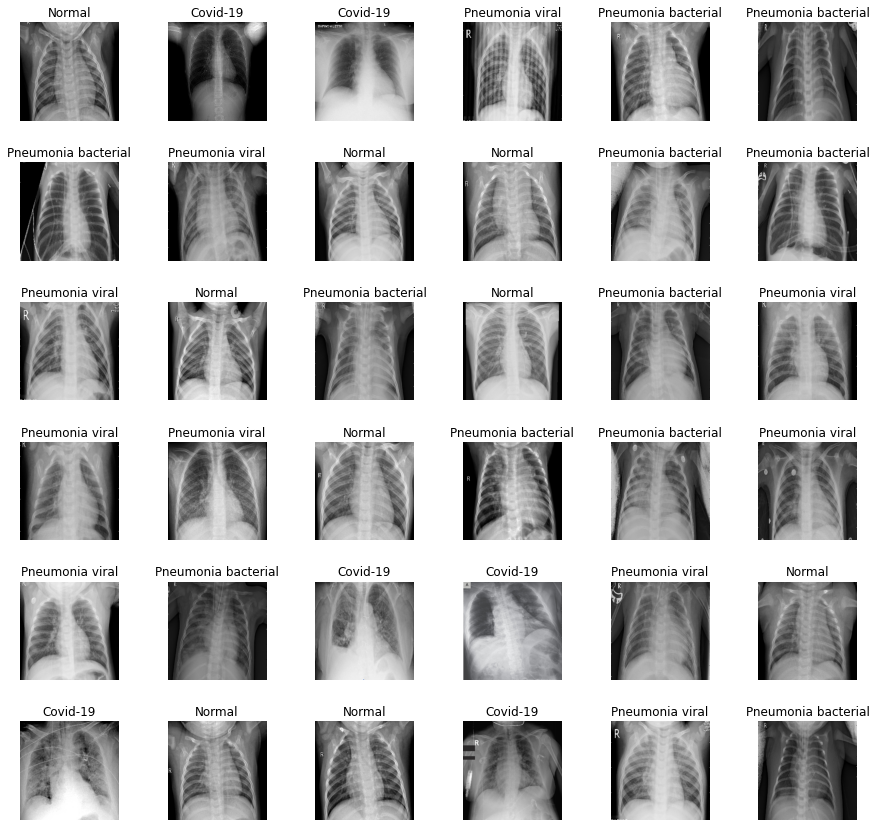

In [9]:
fig, axis = plt.subplots(6, 6, figsize=(15, 15))
axis = axis.ravel()
for i in np.arange(0, 36):
    axis[i].imshow(train_images[i])
    axis[i].set_title(labels_names[np.argmax(train_labels[i])])
    axis[i].axis('off')
plt.subplots_adjust(wspace=0.5)


In [10]:
# importando dados de uma rede neural que já foi treinada
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

2022-08-12 18:37:47.497825: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ronaldy/Desktop/hospital/medico/medico/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-12 18:37:47.497868: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-12 18:37:47.497885: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ronaldy-Inspiron-3583): /proc/driver/nvidia/version does not exist
2022-08-12 18:37:47.498338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler

In [11]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [12]:
len(base_model.layers)

175

In [13]:
for layer in base_model.layers[:-10]:
    layers.trainable = False

In [14]:
head_model = base_model.output
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
head_model = Dense(128, activation ='relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(128, activation ='relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4, activation = 'softmax')(head_model)

In [15]:
model = Model(inputs=base_model.input, outputs=head_model)

In [16]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4, decay=1e-6),
              metrics=['accuracy'])

/home/ronaldy/Desktop/hospital/medico/medico/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [17]:
checkpointer = ModelCheckpoint(filepath='weights.hdf5')

In [18]:
# selecionar imagens de treinamento
train_generator = image_generator.flow_from_directory(batch_size=4, directory=xray_directory, 
                                                      shuffle=True, target_size=(256, 256),
                                                      class_mode='categorical', subset='training')

Found 532 images belonging to 4 classes.


In [19]:
history = model.fit_generator(train_generator, epochs=10, callbacks=[checkpointer])

Epoch 1/10


/tmp/ipykernel_3134/2802061019.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=10, callbacks=[checkpointer])


133/133 [==============================] - 359s 3s/step - loss: 0.9152 - accuracy: 0.7237
Epoch 2/10
133/133 [==============================] - 350s 3s/step - loss: 0.4510 - accuracy: 0.8759
Epoch 3/10
133/133 [==============================] - 349s 3s/step - loss: 0.3971 - accuracy: 0.9117
Epoch 4/10
133/133 [==============================] - 350s 3s/step - loss: 0.2561 - accuracy: 0.9436
Epoch 5/10
133/133 [==============================] - 348s 3s/step - loss: 0.1417 - accuracy: 0.9680
Epoch 6/10
133/133 [==============================] - 362s 3s/step - loss: 0.1556 - accuracy: 0.9680
Epoch 7/10
133/133 [==============================] - 370s 3s/step - loss: 0.1597 - accuracy: 0.9680
Epoch 8/10
133/133 [==============================] - 369s 3s/step - loss: 0.2546 - accuracy: 0.9699
Epoch 9/10
133/133 [==============================] - 368s 3s/step - loss: 0.1215 - accuracy: 0.9718
Epoch 10/10
133/133 [==============================] - 363s 3s/step - loss: 0.0511 - accuracy: 0.9868


In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

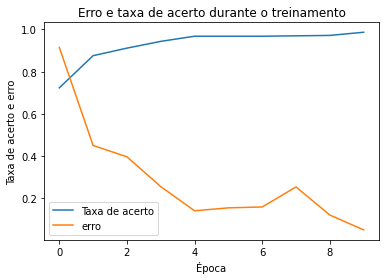

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'erro'])

In [22]:
test_directory = '/home/ronaldy/Desktop/hospital/medico/Test'
os.listdir(test_directory)

['2', '1', '3', '0']

In [23]:
from sklearn.utils import shuffle


test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size=40, directory=test_directory,
                 shuffle=True, target_size=(256, 256), class_mode='categorical')

Found 40 images belonging to 4 classes.


In [24]:
evaluate = model.evaluate_generator(test_generator)

/tmp/ipykernel_3134/163143068.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator)


In [25]:
evaluate

[3.281473159790039, 0.75]

In [26]:
from http.client import PRECONDITION_REQUIRED
from xml.sax.saxutils import prepare_input_source


prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img = cv2.imread(os.path.join(test_directory, str(i), item))
        img = cv2.resize(img, (256, 256))
        image.append(img)
        img = img / 255
        img = img.reshape(-1, 256, 256, 3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)

1/1 [==============================] - 0s 115ms/step


In [27]:
print(prediction)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 3, 2, 2, 2, 1, 3, 0, 3, 3, 1, 1, 3, 3, 3, 3]


In [28]:

print(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [30]:
accuracy_score(original, prediction)

0.775

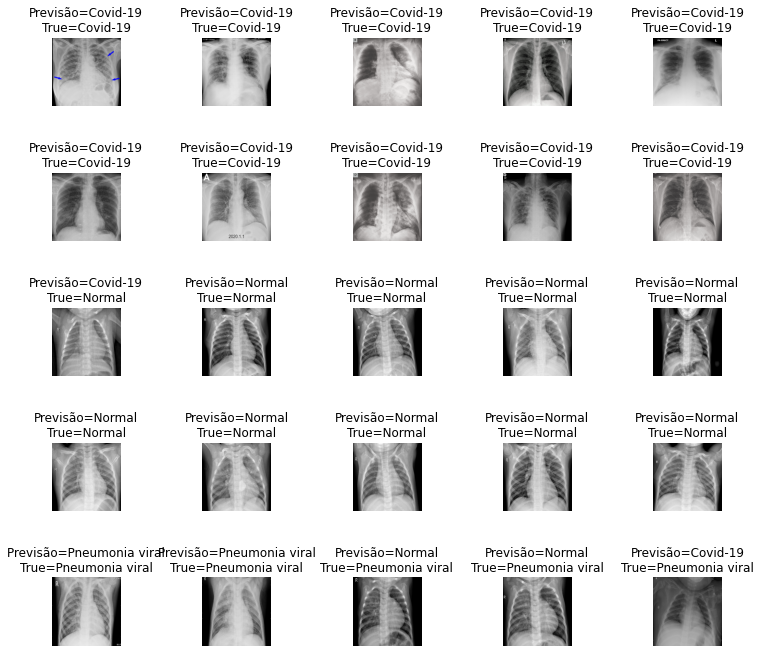

In [31]:
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.ravel()
for i in np.arange(0, 25):
    axes[i].imshow(image[i])
    axes[i].set_title('Previsão={}\nTrue={}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
    axes[i].axis('off')
plt.subplots_adjust(wspace=1.2)

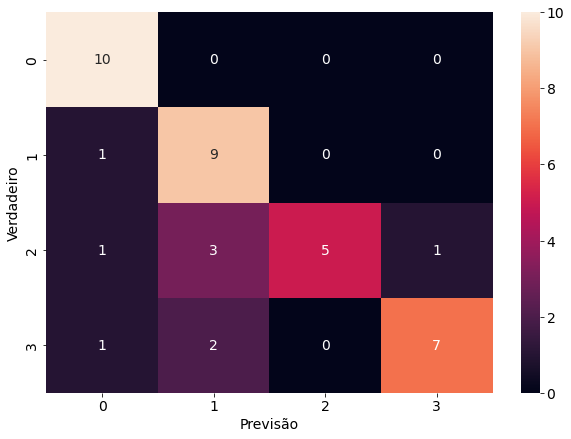

In [32]:
matriz = confusion_matrix(original, prediction)
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10, 7))
sns.heatmap(matriz, annot=True)
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.show()

In [33]:
labels_names

{0: 'Covid-19', 1: 'Normal', 2: 'Pneumonia viral', 3: 'Pneumonia bacterial'}

Classificação de apenas uma imagem

In [34]:
from keras.models import load_model

In [35]:
model_loaded = load_model('weights.hdf5')
model_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [36]:
img = cv2.imread('/home/ronaldy/Desktop/hospital/medico/Test/0/1-s2.0-S0929664620300449-gr2_lrg-b.jpg')
img

array([[[ 44,  44,  44],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [255, 255, 255],
        [253, 253, 253],
        [254, 254, 254]],

       [[ 46,  46,  46],
        [  2,   2,   2],
        [  1,   1,   1],
        ...,
        [255, 255, 255],
        [253, 253, 253],
        [254, 254, 254]],

       [[ 45,  45,  45],
        [  1,   1,   1],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[ 44,  44,  44],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[ 44,  44,  44],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[ 44,  44,  44],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [37]:
img = cv2.resize(img, (256, 256))
img = img / 255
img

array([[[0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        [0.01568627, 0.01568627, 0.01568627],
        ...,
        [0.        , 0.        , 0.        ],
        [0.00784314, 0.00784314, 0.00784314],
        [1.        , 1.        , 1.        ]],

       [[0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        [0.98823529, 0.98823529, 0.98823529],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [1.        , 1.        , 1.        ]],

       [[0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        [1.        , 1.        , 1.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [38]:
img.shape

(256, 256, 3)

In [39]:
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [40]:
predict = model_loaded(img)
predict

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[1., 0., 0., 0.]], dtype=float32)>

In [41]:
predict = np.argmax(predict)
predict

0

In [42]:
labels_names[predict]

'Covid-19'